# Sistemas de control con Python

In [30]:
from scipy.signal import lti
#scipy.signal permite trabajar sistemas lineales en tiempo continuo (LTI)
import matplotlib.pyplot as plt
# matplotlib.pyplot permite realizar gráficas
import sympy as sy
# sympy permite trabajar con matemáticas simbólicas
from sympy import Symbol
import numpy as np
from ipywidgets import interact, fixed

In [31]:
num = [1, 1] #numerador
den = [1, 2, 1] #denominador
sys = lti(num,den) # función de transferencia 

In [32]:
sys

TransferFunctionContinuous(
array([1., 1.]),
array([1., 2., 1.]),
dt: None
)

In [33]:
t,y=sys.step()

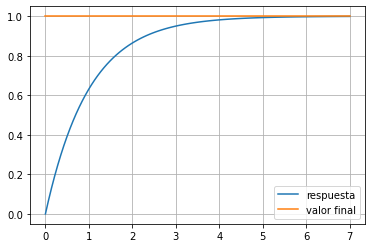

In [38]:
plt.plot(t,y,label='respuesta')
plt.plot([0,t[-1]], [1]*2, label='valor final')
plt.legend()
plt.grid()
plt.show()

In [35]:
y[-1]

0.9990881180344455

In [36]:
def pretysys(sys):
    s = sy.symbols('s')
    num = sy.Poly(sys.num, s)
    den = sy.Poly(sys.den, s)
    return num/den

In [37]:
pretysys(sys)

(1.0*s + 1.0)/(1.0*s**2 + 2.0*s + 1.0)

In [9]:
sys2 = lti([2],[1, 2, 3])

In [10]:
pretysys(sys2)

2.0/(1.0*s**2 + 2.0*s + 3.0)

In [11]:
def serie(sys1, sys2):
    num = np.polymul(sys1.num, sys2.num)
    den = np.polymul(sys1.den, sys2.den)
    return lti(num,den)

In [12]:
a = lti([2],[1,2])
b = lti([1], [1,2,3])

In [13]:
pretysys(a)

2.0/(1.0*s + 2.0)

In [14]:
pretysys(b)

1.0/(1.0*s**2 + 2.0*s + 3.0)

In [15]:
pretysys(serie(a,b))

2.0/(1.0*s**3 + 4.0*s**2 + 7.0*s + 6.0)

funcion_t_open_loop = $G(s)$

fun_t_feedback = $H(s)$

$$GH(s) = \frac{G(s)}{1+G(s)\cdot H(s)} = \frac{GN\cdot HD}{GN\cdot HN + GD\cdot HG}$$    

In [16]:
def feedback(sys1, sys2):
    num=np.polymul(sys1.num, sys2.den)
    a = np.polymul(sys1.num, sys2.num)
    b = np.polymul(sys1.den, sys2.den)
    den = np.polyadd(a,b)
    return lti(num,den)

In [17]:
pretysys(feedback(a,b))

(2.0*s**2 + 4.0*s + 6.0)/(1.0*s**3 + 4.0*s**2 + 7.0*s + 8.0)

# Diseño de un controlador PI mediante asignación de polos

In [18]:
def PI(sys, Mp=0.1, ts=2, p_sys=False):
    K=sys.num[0]
    tau = sys.den[0]
    z = 1/np.sqrt(1+(np.pi/np.log(Mp)**2))
    w = 4/(ts*z)
    kp = (2*z*w*tau-1)/K
    ki = (w**2)/K
    return lti([kp, ki],[1,0])

In [19]:
planta = lti(0.8,[0.5,1])
pretysys(planta)

1.6/(1.0*s + 2.0)

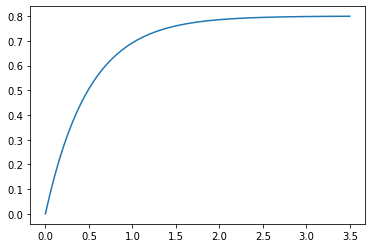

In [20]:
t,y = planta.step()
plt.plot(t,y)

In [21]:
pi = PI(planta,Mp=0.15,ts=1.0)
ser = serie(planta,pi)
feed = feedback(ser,lti(1,1))

In [22]:
t1,y1 = feed.step(T=t)

<function matplotlib.pyplot.show(close=None, block=None)>

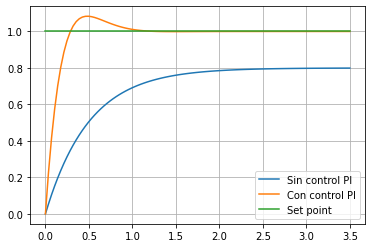

In [23]:
# %matplotlib notebook
plt.plot(t,y,label='Sin control PI')
plt.plot(t1,y1,label='Con control PI')
plt.plot([t[0],t[-1]],[1]*2,label='Set point')
plt.legend(loc='best')
plt.grid()
plt.show

# PID interactivo

In [24]:
def param(t,y):
  n=0 #indice del tiempo de levantamiento
  vf=y[-1]#valor final de la respuesta
  tp=t[np.argmax(y)] # tiempo pico
  Ma=(max(y)-y[-1])/y[-1]#porcentaje de maximo sobreimpulso

  while y[n]<vf:
    n+=1
  
  tl=t[n]#tiempo de levantamiento

  e=abs(y-vf) #error absoluto

  ei=e[::-1]#error en orden invertido
  
  m=1 #indice del tiempo de establecimiento

  while ei[m]<2*vf/100:
    m+=1
  
  ts=t[-m]# tiempo de establecimiento al 2%

  return print(f'%Amax={Ma*100}\nVf={vf}\ntp={tp}\ntl={tl}\nts={ts}')

In [25]:
def pid_tuner(sys,ret=0.0,kp=10,ki=10,kd=10,delta_P=0.01,delta_I=0.01,delta_D=0.01):

  @interact(kp=(0.001,kp,delta_P),ki=(0.001,ki,delta_I),kd=(0.001,kd,delta_D),param_orig=['Yes','No'],param_cont=['Yes','No'])
  def CONTROLAR(kp,ki,kd,param_orig,param_cont):
    ts,ys=sys.step()
    plt.plot(ts,ys,label='Sistema sin controlar')
    plt.legend(loc='best')
    cont=lti([kd,kp,ki],[1,0])
    ser=serie(cont,sys)
    fed=feedback(ser,lti([1],[1]))
    tc,yc=fed.step(T=ts)
    plt.plot(tc,yc,label='Sistema controlado')
    plt.legend(loc='best')
    plt.title('PID')
    plt.xlabel('T(s)')
    plt.ylabel('Amplitud')
    plt.grid()
    plt.show
    if param_orig=="Yes":
      print('\n Parametros del sistema origianal')
      param(ts,ys)
    
    if param_cont=='Yes':
      print('\n Parametros del sistema controlado')
      param(tc,yc)

In [26]:
sys=lti([2],[1,2,3])

In [27]:
pid_tuner(sys)

interactive(children=(FloatSlider(value=4.9910000000000005, description='kp', max=10.0, min=0.001, step=0.01),…